Code for GAN model for Audio generation created using LSTM

Generated Audio will be saved in a folder named "Generated_Audio" in the same path where jupyternote book in located or colab.

Number of epochs to run can be changed in Hyperparameter section.

Batch size can also be changed in the same section. We were using 64 as batch size but tried reducing it to 32 irorder to sustain with the memory limitation we had

In [7]:
pip install pydub

#### Import Required libraries

In [8]:
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
from pydub import AudioSegment
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from scipy.linalg import sqrtm
from IPython.display import Audio
from scipy.io import wavfile


#### Load Dataset

In [9]:
# Defining dataset path where data will be loaded
DATASET_PATH = 'data/mini_speech_commands'

# This code will download and extract the dataset in the specified path if not already exist
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.',
        cache_subdir='data'
    )

In [10]:
# This code reads the README file and shows which commands are specified in the dataset
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'left' 'up' 'no' 'stop' 'go' 'right' 'yes']


#### Spilt data into test and train

In [11]:
# Splitting the data into training and validation 80:20 ratio
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    subset='training',
    seed=0,
    output_sequence_length=16000
)

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    subset='validation',
    seed=0,
    output_sequence_length=16000
)


label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Found 8000 files belonging to 8 classes.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


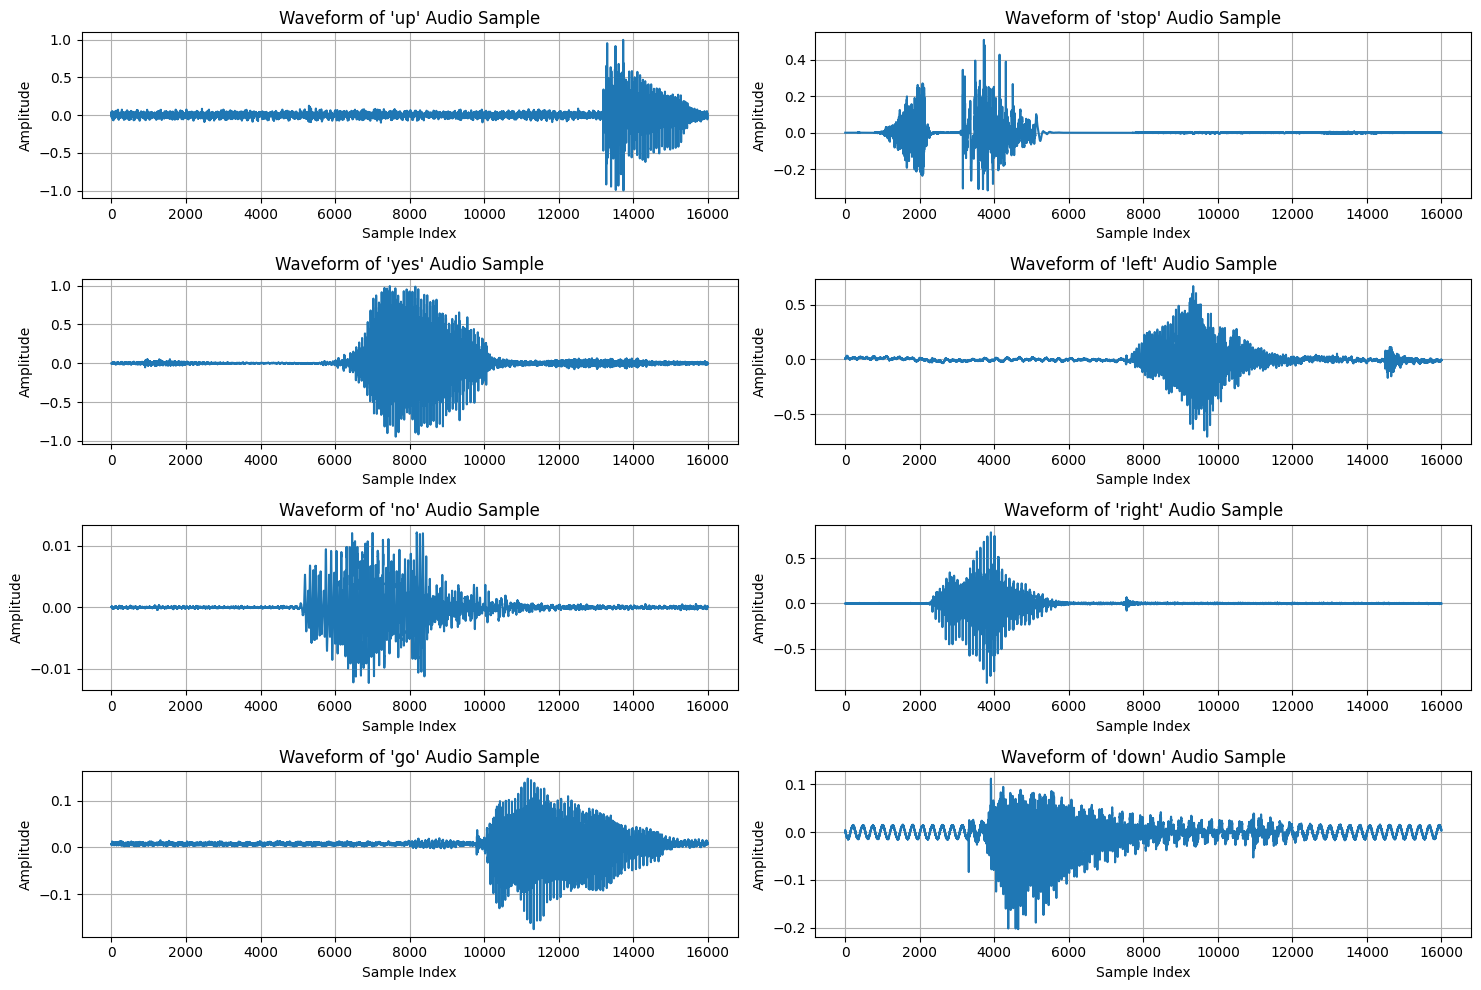

In [12]:
def plot_waveform(audio_sample, label):
    sample_audio_np = audio_sample.numpy()
    plt.plot(sample_audio_np)
    plt.title(f"Waveform of '{label}' Audio Sample")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)

# Define the words for which we want to plot the waveforms
words_to_plot = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

# Create a single figure for plotting
plt.figure(figsize=(15, 10))

# Extract and plot the waveforms for the specified words
for audio_batch, label_batch in train_ds:
    for audio_sample, label in zip(audio_batch, label_batch):
        label_name = label_names[label.numpy()]
        if label_name in words_to_plot:
            plt.subplot(4, 2, len(words_to_plot))  # Create a subplot for each word
            plot_waveform(audio_sample, label_name)
            words_to_plot.remove(label_name)
            if len(words_to_plot) == 0:
                break
    if len(words_to_plot) == 0:
        break

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

#### Build Genrator and Discriminator Model using LSTM

In [13]:
# generator model using an LSTM
def build_generator(latent_dim, sequence_length):
    model = Sequential()
    model.add(LSTM(64, input_shape=(sequence_length, latent_dim)))
    model.add(Dense(sequence_length))
    return model
# discriminator model using an LSTM
def build_discriminator(sequence_length):
    model = Sequential()
    model.add(LSTM(64, input_shape=(sequence_length, 1)))  # Input shape is (sequence_length, 1)
    model.add(Dense(1, activation='sigmoid'))
    return model

#### Define GAN

In [14]:
# GAN model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model


#### Hyperparameters

In [15]:
# Hyperparameters
latent_dim = 100  # Dimension of the noise vector
sequence_length = 16000  # Length of input sequences
batch_size = 64
epochs = 1 #change this as needed start with 2 and try till 100 or 500

#### Compile models

In [16]:
# Build and compile the models
generator = build_generator(latent_dim, sequence_length)
discriminator = build_discriminator(sequence_length)
gan = build_gan(generator, discriminator)

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')

generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 16000)             1040000   
                                                                 
Total params: 1,082,240
Trainable params: 1,082,240
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Tra

In [17]:
# Build and compile the generator model
generator_early_stopping = build_generator(latent_dim, sequence_length)
generator_early_stopping.compile(loss='binary_crossentropy', optimizer='adam')

# Build and compile the discriminator model
discriminator_early_stopping = build_discriminator(sequence_length)
discriminator_early_stopping.compile(loss='binary_crossentropy', optimizer='adam')

# Build and compile the GAN model for early stopping
gan_early_stopping = build_gan(generator_early_stopping, discriminator_early_stopping)
gan_early_stopping.compile(loss='binary_crossentropy', optimizer='adam')

#### Define Early Stopping

In [18]:
class EarlyStoppingGAN(Callback):
    def __init__(self, generator, patience=3, restore_best_weights=True):
        super(EarlyStoppingGAN, self).__init__()
        self.generator = generator
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_loss = float('inf')  # Initialize best_loss to positive infinity
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is None:
            return

        if self.best_weights is None:
            self.best_weights = self.generator.get_weights()
            self.wait = 0

        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_weights = self.generator.get_weights()
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    self.generator.set_weights(self.best_weights)
                print("No improvement observed for {} consecutive epochs - Triggering Early stopping for GAN!".format(self.patience))

#gan_early_stopping = EarlyStoppingGAN(generator_early_stopping)
gan_early_stopping = EarlyStoppingGAN(generator_early_stopping, restore_best_weights=True)

In [19]:
#pip install pydub

#### Train the model

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import librosa
from pydub import AudioSegment

# sample rate for audio data
sample_rate = 16000

# path of generated audio files
output_folder = "Generated_Audio"
os.makedirs(output_folder, exist_ok=True)

# Lists to store the discriminator, generator, and validation losses at each epoch
d_losses = []
g_losses = []
val_losses = []
fid_values = []

# Save Audio Function
def save_generated_audio(epoch, step, generated_data):
    if step == len(train_ds) - 1:  # Save only for the last step of each epoch
        for j in range(batch_size):
            audio_data = (generated_data[j, :, 0] * 32767.0).astype(np.int16)  # Scaling and converting to 16-bit PCM
            filename = f"generated_audio_epoch{epoch + 1}_step{step + 1}_sample{j + 1}.wav"
            full_save_path = os.path.join(output_folder, filename)
            wavfile.write(full_save_path, sample_rate, audio_data)

# # Define Early Stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



# Training loop
for epoch in range(epochs):
    # Shuffle the training dataset
    train_ds.shuffle(buffer_size=batch_size * 10)  # Shuffle the data for better training

    #for i in range(len(train_ds)):
    for i, (real_data, real_labels) in enumerate(train_ds):
        # if i >= 10:
        #   break  # Running only for 2 steps for testing

        # random noise as input to the generator
        noise = np.random.normal(0, 1, (batch_size, sequence_length, latent_dim))

        # fake data generated using
        generated_data = generator.predict(noise)

        # get a batch of real data and separate into real_data and real_labels
        batch_real = next(iter(train_ds))
        real_data, real_labels = batch_real[0], batch_real[1]

        # reshaping generated_data to match real_data's shape
        generated_data = generated_data[:, :, np.newaxis]

        # create separate batches for real and generated data with the same batch_size
        X_real = real_data[:batch_size]
        X_generated = generated_data[:batch_size]

        # concatenate real and generated data for the discriminator
        X = np.concatenate([X_real, X_generated])

        # create labels for the discriminator: 0 for real data, 1 for generated data
        y_discriminator_real = np.ones((batch_size, 1))  # Label for real data
        y_discriminator_fake = np.zeros((batch_size, 1))  # Label for generated data

        # train the discriminator
        d_loss_real = discriminator.train_on_batch(X_real, y_discriminator_real)
        d_loss_fake = discriminator.train_on_batch(X_generated, y_discriminator_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  # Average loss for real and generated data

        # generate noise for the generator
        noise = np.random.normal(0, 1, (batch_size, sequence_length, latent_dim))

        # labels for the generator
        y_generator = np.ones((batch_size, 1))

        # train the generator
        g_loss = gan.train_on_batch(noise, y_generator)

        # printing progress
        print(f"Epoch {epoch + 1}/{epochs}, Step {i + 1}/{len(train_ds)}, D Loss: {d_loss}, G Loss: {g_loss}")

        # Append the discriminator and generator losses for this step to the lists
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    # # # Calculate FID at the end of each epoch
    # fid = calculate_fid(real_data, generated_data, batch_size)
    # fid_values.append(fid)

    # # # Plot spectrogram comparison at the end of each epoch
    # plot_spectrogram(real_data[0], generated_data[0], sample_rate, f"Epoch {epoch + 1} Spectrogram Comparison")

    # Play back real and generated audio samples at the end of each epoch
    real_audio = real_data[0, :, 0]
    generated_audio = (generated_data[0, :, 0] * 32767.0).astype(np.int16)
    display(Audio(real_audio, rate=sample_rate))
    display(Audio(generated_audio, rate=sample_rate))

    # Calculate validation loss
    val_loss = 0.0
    for val_real_data, _ in val_ds:
        val_noise = np.random.normal(0, 1, (batch_size, sequence_length, latent_dim))
        val_generated_data = generator_early_stopping.predict(val_noise)

        # Preprocess generated data to match the shape expected by the discriminator
        val_generated_data = val_generated_data[:, :, np.newaxis]

        # Create labels for validation
        y_discriminator_real = np.ones((batch_size, 1))
        y_discriminator_fake = np.zeros((batch_size, 1))

        # Evaluate the discriminator on real and generated data
        val_loss += (discriminator_early_stopping.evaluate(val_real_data, y_discriminator_real, verbose=0) +
                     discriminator_early_stopping.evaluate(val_generated_data, y_discriminator_fake, verbose=0))

    val_loss /= len(val_ds)  # Average over batches
    print(f"Validation Loss after Epoch {epoch + 1}: {val_loss}")


    # # # Plot MFCCs comparison at the end of each epoch
    # plot_mfccs(real_data[0, :, 0], generated_data[0, :, 0], sample_rate, f"Epoch {epoch + 1} MFCCs Comparison")

    # Check for early stopping for the GAN
    if gan_early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss}):
        print("No improvement observed for 3 consecutive epochs - Triggering Early stopping for GAN!")
        break

    # Save the generated audio at the end of each epoch
    save_generated_audio(epoch, i, generated_data)




2/2 [==============================] - 6s 321ms/step
Epoch 1/1, Step 1/100, D Loss: 0.6932684779167175, G Loss: 0.693089485168457
2/2 [==============================] - 1s 214ms/step
Epoch 1/1, Step 2/100, D Loss: 0.693225771188736, G Loss: 0.6929649710655212
2/2 [==============================] - 1s 218ms/step
Epoch 1/1, Step 3/100, D Loss: 0.6933617293834686, G Loss: 0.6928804516792297
2/2 [==============================] - 1s 208ms/step
Epoch 1/1, Step 4/100, D Loss: 0.6933015286922455, G Loss: 0.6924561858177185
2/2 [==============================] - 1s 214ms/step
Epoch 1/1, Step 5/100, D Loss: 0.693463146686554, G Loss: 0.6925917863845825
2/2 [==============================] - 1s 207ms/step
Epoch 1/1, Step 6/100, D Loss: 0.6935303807258606, G Loss: 0.6923465728759766
2/2 [==============================] - 1s 212ms/step
Epoch 1/1, Step 7/100, D Loss: 0.693546712398529, G Loss: 0.6919424533843994
2/2 [==============================] - 1s 212ms/step
Epoch 1/1, Step 8/100, D Loss: 0.6

2/2 [==============================] - 1s 214ms/step
Validation Loss after Epoch 1: 1.3862303972244263


#### Plot the graphs

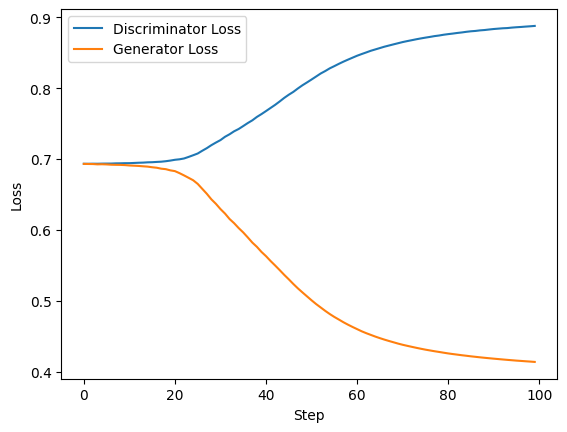

In [21]:
# Plot the discriminator and generator losses
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Dump required data into Pickle file

In [22]:
import pickle

In [23]:
# Save the loss data
loss_data = {
    'd_losses': d_losses,
    'g_losses': g_losses,
}
with open('loss_data.pkl', 'wb') as f:
    pickle.dump(loss_data, f)

In [24]:
# Save the validation losses
validation_losses = {
    'epoch': epoch,
    'val_loss': val_loss,
}
with open('validation_losses.pkl', 'wb') as f:
    pickle.dump(validation_losses, f)

In [25]:
# Save the generated audio samples
generated_audio_data = {
    'epoch': epoch,
    'step': i,
    'generated_data': generated_data,
}
with open('generated_audio_data.pkl', 'wb') as f:
    pickle.dump(generated_audio_data, f)

In [26]:
# Save model architectures and hyperparameters
model_info = {
    'generator_architecture': generator.to_json(),
    'discriminator_architecture': discriminator.to_json(),
    'latent_dim': latent_dim,
    'sequence_length': sequence_length,
    'batch_size': batch_size,
    'epochs': epochs,
}
with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)